# Normalized graph cuts within ball

Code was created with accordance to article by Wenbing Tao, Hai Jin, Yimin Zhang, Liman Liu, and Desheng Wang.
<br>
Link: https://ieeexplore.ieee.org/document/4604825

In [8]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import math
import time
from datetime import timedelta
from skimage import io, filters, measure
from scipy import ndimage, spatial
import networkx as nx

In [13]:
# Graph does not need to be directed - we work directly only on ,,cut matrix"
# arr is array of image in grayscale (width x height) - it's elements are intenisities of pixels
# I - sensivity of weights for intensity changes
# X - sensivity of weights for spatial location between nodes

# Define function finding median for correct quartile calculations

def find_median(sorted_list):
    indices = []

    list_size = len(sorted_list)
    median = 0

    if list_size % 2 == 0:
        indices.append(int(list_size / 2) - 1)  # -1 because index starts from 0
        indices.append(int(list_size / 2))

        median = (sorted_list[indices[0]] + sorted_list[indices[1]]) / 2
        pass
    else:
        indices.append(int(list_size / 2))

        median = sorted_list[indices[0]]
        pass

    return median, indices

# Create cut matrix for an image

def create_cut_matrix(arr, I, X, radius):
    
    M = np.zeros((256,256))
    points = []
    width = arr.shape[0]
    height = arr.shape[1]
    
    for i in range(width):
        for j in range(height):
            points.append((i,j))
            
    points = np.asarray(points)
    
    Tree = spatial.KDTree(points, radius)
    
    def set_capacity(x1, y1, x2, y2, I, X):
        
        dist = spatial.distance.pdist([(x1,y1),(x2,y2)],'euclidean')
        capacity = np.exp( - ((abs(arr[x1][y1] - arr[x2][y2]) / I + dist / X )) )
    
        return capacity

    for x in points:
        
        idx = Tree.query_ball_point(x, radius)
        for y in points[idx]:
            
            capacity = set_capacity(x[0], x[1], y[0], y[1], I, X)
            M[arr[x[0]][x[1]]][arr[y[0]][y[1]]] += capacity
            M[arr[y[0]][y[1]]][arr[x[0]][x[1]]] += capacity
            
    return M

# Define function that returns optimal cut for given cut matrix M, threshold of cut t and minimal cut

def get_NCut(t, M, NCut_min):
    
    cutAB = 0                                # cut with sets A and B
    assoAA = 0                               # sum of weights between pixels in A
    assoBB = 0                               # sum of weights between pixels in B
    
    for i in range(0,t+1):
        for j in range(t+1,256):
            cutAB += M[i][j]
            
    for i in range(0,t+1):
        for j in range(i,t+1):
            assoAA += M[i][j]
            
    for i in range(t+1,256):
        for j in range(i,256):
            assoBB += M[i][j]
            
    A = assoAA + cutAB
    B = assoBB + cutAB
    
    if A != 0 and B != 0:
        NCutAB = (cutAB / A) + (cutAB / B)    # get normalized cut
    else:
        NCutAB = NCut_min
        
    return NCutAB

# Get optimal threshold that results in minimal normalized cut for given ,,cut matrix" M 

def get_treshold(M):
    
    # Initialization
    t = 0
    t_min = 0
    NCut_min = 2
    
    # Search for best treshold and cut
    while t <= 255:
        NCutAB = get_NCut(t, M, NCut_min)
        if NCutAB < NCut_min:
            NCut_min = NCutAB
            t_min = t
        t += 1
        
    return NCut_min, t_min

# Process image with obtained threshold

def treshold_image(arr, treshold):
    
    result = arr
    width = arr.shape[0]
    height = arr.shape[1]
    
    for i in range(width):
        for j in range(height):
            if arr[i][j] > treshold :
                result[i][j] = 0
            else:
                result[i][j] = 1
                
    return result

In [14]:
# Create graph ,,binary graph" used for DFS search in thresholded image
# reached == 0 => node was not reached during DFS 
# weight == 0 or 1 depending on image binary threshold 

def create_binary_graph(im_arr):
    G = nx.Graph()
    for i in range(im_arr.shape[0]):
        for j in range(im_arr.shape[1]):
            G.add_node((i,j), weight = im_arr[i][j], reached = 0)      
            if i > 0:
                G.add_edge((i,j),(i-1,j))  
                if j > 0:
                    G.add_edge((i-1,j-1),(i,j))
                if j < im_arr.shape[0] - 1:
                    G.add_edge((i-1,j+1),(i,j))
            if j > 0:
                G.add_edge((i,j),(i,j-1))
    return G

# Count different objects by colouring DFS trees for thresholded image

def colouring_binary_picture(image_array):
    
    #Initialization
    G = create_binary_graph(image_array)
    result = image_array
    colour = 50
    stack = []
    colours = []
    
    # DFS iterative way + colour assignment
    for node in G.nodes():
        counter = 0
        if G.nodes[node]['reached'] == 0 and G.nodes[node]['weight'] == 1:
            counter += 1
            colour += 1
            G.nodes[node]['reached'] = 1
            result[node[0]][node[1]] = colour
            stack.append(node)
            while len(stack) != 0:
                taken_node = stack.pop(0)
                counter += 1
                for neighbor in G.neighbors(taken_node):
                    if G.nodes[neighbor]['reached'] == 0 and G.nodes[neighbor]['weight'] == 1:
                        G.nodes[neighbor]['reached'] = 1
                        result[neighbor[0]][neighbor[1]] = colour
                        stack.append(neighbor)
                 
            colours.append([colour, counter])
    
    return colours, result
           
def find_outliners(colours):

    values = []
    outliners = []
    
    for x in colours:
        values.append(x[1])

    median, median_indices = find_median(sorted(values))
    Q1, Q1_indices = find_median(sorted(values)[:median_indices[0]])
    Q3, Q3_indices = find_median(sorted(values)[median_indices[-1] + 1:])
    
    for x in colours:
        if Q1 < x[1] and x[1] < Q3 + 1.5 * (Q3 - Q1):
            pass
        else:
            outliners.append(x[0])
                
    return outliners

# Remove too small or too big objects 
# Note: All thresholds for saying that something is ,,big" or ,,small" are (for now!) assigned in experimental way
#   Later I will try to set down an automatic threshold for such details

def remove_banned_objects(colour_array, outliners):
    
    result = colour_array
    
    for i in range(colour_array.shape[0]):
        for j in range(colour_array.shape[1]):
            if colour_array[i][j] in outliners:
                result[i][j] = 0
                
    return result

In [15]:
# image is an unopened picture, I and X need to be specified by user (possible automatic detection ??)

def pipeline(image, I, X, radius):
    
    im = Image.open(image).convert('L')
    
    im_arr = np.array(im, dtype='int64')    # int for possibility to iterate!
    
    # Threshold picture by cut matrix method
    
    M = create_cut_matrix(im_arr, I, X, radius)
    
    N, T = get_treshold(M)
    
    threshold_result = treshold_image(im_arr, T)
    
    # Process obtained picture for possibility to properly count the bees
    
    colours, colour_result = colouring_binary_picture(threshold_result)
    
    banned_colours = find_outliners(colours)
    
    result = remove_banned_objects(colour_result, banned_colours)
    
    # Number of bees equals to all different colours used minus colour "0" for the background
    
    unique_values = np.unique(result) 
    
    counter = len(unique_values) - 1
    
    print('There are {} objects in the image.'.format(counter))
    
    return result

There are 25 objects in the image.
Time of calcualtions: 0:02:58.062000


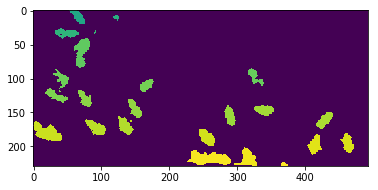

In [65]:
start_time = time.monotonic()
result = pipeline('3.png', 625, 4, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 15 objects in the image.
Time of calcualtions: 0:12:24.719000


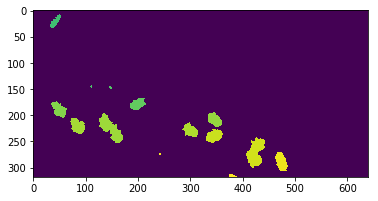

In [22]:
start_time = time.monotonic()
result = pipeline('2.png', 625, 4, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 18 objects in the image.
Time of calcualtions: 0:06:35.891000


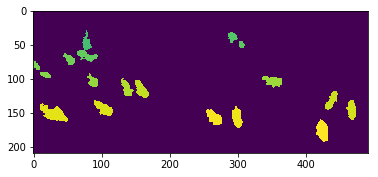

In [68]:
start_time = time.monotonic()
result = pipeline('5.png', 625, 4, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 16 objects in the image.
Time of calcualtions: 0:08:42.562000


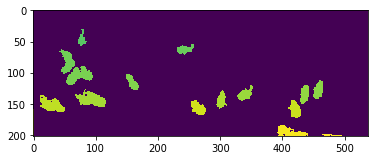

In [69]:
start_time = time.monotonic()
result = pipeline('6.png', 625, 4, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 20 objects in the image.
Time of calcualtions: 0:08:44.500000


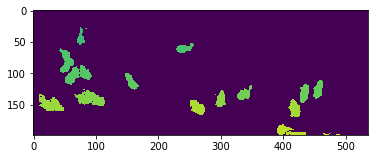

In [71]:
start_time = time.monotonic()
result = pipeline('7.png', 625, 4, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 145 objects in the image.
Time of calcualtions: 0:21:09.609000


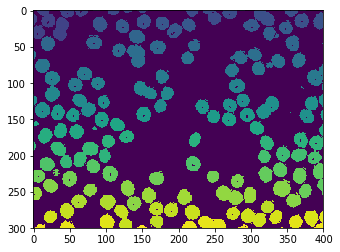

In [16]:
start_time = time.monotonic()
result = pipeline('red_blood_cells.png', 625, 4, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 9 objects in the image.
Time of calcualtions: 0:19:47.656000


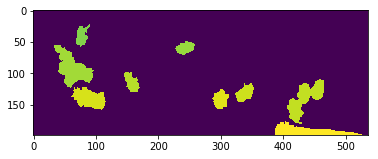

In [18]:
start_time = time.monotonic()
result = pipeline('7.png', 625, 0.6, 6)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 9 objects in the image.
Time of calcualtions: 0:09:17.672000


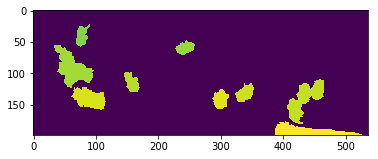

In [19]:
start_time = time.monotonic()
result = pipeline('7.png', 625, 6, 6)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 9 objects in the image.
Time of calcualtions: 0:06:21.531000


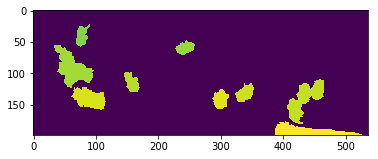

In [21]:
start_time = time.monotonic()
result = pipeline('7.png', 1024, 800, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)